# Introduction
Calculates intra-movement DKL values for each movement (as divided into 6 parts) and graphs this against frequency.

# Setup

In [3]:
from music21 import *
import os
import csv
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import statsmodels
from IPython.display import Image
import math

# Verticalities

In [20]:
## load corpus

properCorpus = corpus.corpora.LocalCorpus('DPhilCorpus')
properCorpus.existsInSettings

properCorpus.addPath('~/Desktop/Oxford/Corpus/Sounding Corpus (Movements)/XML/')
properCorpus.directoryPaths

properCorpus.save()
properCorpus.existsInSettings

/opt/anaconda3/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: DPhilCorpus metadata cache: starting processing of paths: 107
/opt/anaconda3/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: filename: /var/folders/cr/p20lv70n2wbf2w8jfmxbh69w0000gp/T/music21/local-DPhilCorpus.p.gz
bundles.py: WARNING: MetadataBundle Modification Time: 1608726106.311569
bundles.py: WARNING: Skipped 56 sources already in cache.
bundles.py: WARNING: updated 1 of 51 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements)/XML/Op. 27 i.xml
bundles.py: WARNING: updated 2 of 51 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements)/XML/Op. 27 ii.xml
bundles.py: WARNING: updated 3 of 51 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements)/XML/Op. 27 iii.xml
bundles.py: WARNING: updated 4 of 51 files; total erro

bundles.py: WARNING: updated 50 of 51 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements)/XML/Op. 9 v.xml
bundles.py: WARNING: updated 51 of 51 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements)/XML/Op. 9 vi.xml
/opt/anaconda3/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: writing time: 63.825 md items: 107

/opt/anaconda3/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: filename: /var/folders/cr/p20lv70n2wbf2w8jfmxbh69w0000gp/T/music21/local-DPhilCorpus.p.gz


True

In [21]:
## organise corpus

pieceName = []

listOfWorks = properCorpus.search('Op.')
for el in listOfWorks:
    pieceName.append(el.sourcePath)

In [22]:
## record the offset of each VT in each movement

list_of_info = []
for el in pieceName:
    thePiece = corpus.parse(el)
    fileTitle = str(el).replace("/Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements)/XML/", "").replace(".xml", "").replace(".mxl", "")
    opusNumber = fileTitle.replace("Op.", "").replace(" ", "").replace("i", "").replace("v", "")
    movementNumber = fileTitle.replace("Op.", "").replace(" ", "").replace("1", "").replace("2", "").replace("3", "").replace("4", "").replace("5", "").replace("6", "").replace("7", "").replace("8", "").replace("9", "").replace("0", "")
    chordifiedPiece = thePiece.chordify()
    chords = chordifiedPiece.flat.recurse().getElementsByClass('Chord')
    rests = chordifiedPiece.flat.recurse().getElementsByClass('Chord')
    listOfOffsetsandDurations = []
    for i in range(0, len(chords)-1):
        temp = []
        if str(chords[i].primeForm) == '[0, 1, 6]':
            offset_position = chords[i].offset
            list_of_duration_values = []
            for j in chords:
                if j.offset < offset_position:
                    list_of_duration_values.append(j.seconds)
            for k in rests:
                if k.offset < offset_position:
                    list_of_duration_values.append(k.seconds)
            listOfOffsetsandDurations.append([sum(list_of_duration_values), chords[i].seconds])
    all_chord_durations = []
    all_rest_durations = []
    for l in chords:
        all_chord_durations.append(l.seconds)
    for m in rests:
        all_rest_durations.append(m.seconds)
    temp = []
    temp.append(fileTitle)
    temp.append(listOfOffsetsandDurations)
    temp.append(sum(all_chord_durations)+sum(all_rest_durations))
    list_of_info.append(temp)

In [23]:
## segment each movement into 6 parts and count the number of VT instances in each part; then return DKL values

DKL_values = []
for i in list_of_info:
    total_offsets_range = i[2]/6
    offsets_partitions = []
    for j in range(0, 7):
        offsets_partitions.append(j*total_offsets_range)
    list_of_partitioned_verticality_values = []
    
    for l in range(0, len(offsets_partitions)):
        temp = []
        for k in i[1]:
            val = k[0]
            if val > offsets_partitions[l]:
                if val <= offsets_partitions[l+1]:
                    temp.append(k[1])
        list_of_partitioned_verticality_values.append(temp)
    
    
    
    list_of_partition_number_counts = []

    for k in list_of_partitioned_verticality_values:
        list_of_partition_number_counts.append(sum(k))
    
    
    list_of_plog_values = []
    for l in list_of_partition_number_counts:
        if l == 0:
            list_of_plog_values.append(0)
        else:
            p_value = l/sum(list_of_partition_number_counts)
            plog2pq_value = p_value*math.log2(p_value/(1/6))
            list_of_plog_values.append(plog2pq_value)
    verticality_plog_value = sum(list_of_plog_values)
    DKL_value = 1-(math.exp(-verticality_plog_value))
    DKL_values.append([i[0], DKL_value])
print(DKL_values)

[['Op. 1', 0.8294466438490942], ['Op. 10 i', 0.79504452134466], ['Op. 10 ii', 0.0], ['Op. 10 iii', 0.924601093047248], ['Op. 10 iv', 0.6423876831769093], ['Op. 10 v', 0.924601093047248], ['Op. 11 i', 0.924601093047248], ['Op. 11 ii', 0.8009127098106901], ['Op. 11 iii', 0.0], ['Op. 12 i', 0.8637535256547648], ['Op. 12 ii', 0.7403762987030913], ['Op. 12 iii', 0.8111243971624382], ['Op. 12 iv', 0.924601093047248], ['Op. 13 i', 0.8111243971624381], ['Op. 13 ii', 0.924601093047248], ['Op. 13 iii', 0.6390066177039198], ['Op. 13 iv', 0.6378221330842966], ['Op. 14 i', 0.2932071174329802], ['Op. 14 ii', 0.7253359670250838], ['Op. 14 iii', 0.347210045255555], ['Op. 14 iv', 0.3702113512281978], ['Op. 14 v', 0.48161086479913806], ['Op. 14 vi', 0.5273587084484699], ['Op. 15 i', 0.79504452134466], ['Op. 15 ii', 0.149874656606939], ['Op. 15 iii', 0.29650380506528184], ['Op. 15 iv', 0.6620855427944148], ['Op. 15 v', 0.46582038847240215], ['Op. 16 i', 0.1591653779406107], ['Op. 16 ii', 0.0], ['Op. 16 i

In [24]:
## plot frequency against DKL

verticalities_url_pf = 'https://raw.githubusercontent.com/anonymousmuso/Viennese-Trichord/main/Data/Verticalities%20-%20Prime%20Form.csv'
verticalities_pf = pd.read_csv(verticalities_url_pf, error_bad_lines=False)
verticalities_pf = verticalities_pf.set_index('Title').iloc[:, 11:12]

sorted_DKL_values = []
for i in verticalities_pf.index.values.flat:
    for j in DKL_values:
        if i == j[0]:
            sorted_DKL_values.append(j[1])
verticalities_pf['DKL Values'] = sorted_DKL_values

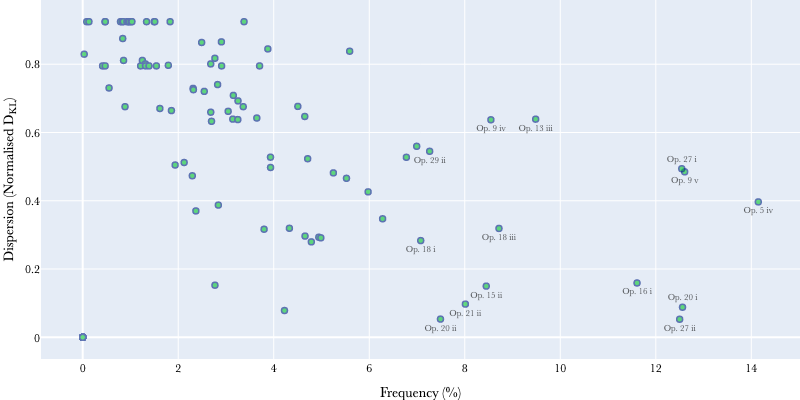

In [25]:
## plot frequency against DKL with anomalies marked

organised_data = verticalities_pf.sort_values(by='[0 1 6]')
organised_data = organised_data.iloc[len(organised_data.index)-16:, :]

organised_data = verticalities_pf.sort_values(by='[0 1 6]')
first_organised_data = organised_data.iloc[len(organised_data.index)-14:, :]
second_organised_data = organised_data.iloc[:len(organised_data.index)-14, :]

third_organised_data = first_organised_data.iloc[10:11, :]
fourth_organised_data = first_organised_data.iloc[11:12, :]
first_organised_data = first_organised_data.drop('Op. 27 i').drop('Op. 20 i')

fig = go.Figure()
fig.add_trace(go.Scatter(x = first_organised_data['[0 1 6]'], y = first_organised_data['DKL Values'], mode='markers+text', text=first_organised_data.index.values, textposition="bottom center", textfont_size=9))
fig.add_trace(go.Scatter(x = second_organised_data['[0 1 6]'], y = second_organised_data['DKL Values'], mode='markers', text=second_organised_data.index.values, textposition="bottom center", textfont_size=9))
fig.add_trace(go.Scatter(x = third_organised_data['[0 1 6]'], y = third_organised_data['DKL Values'], mode='markers+text', text=third_organised_data.index.values, textposition="top center", textfont_size=9))
fig.add_trace(go.Scatter(x = fourth_organised_data['[0 1 6]'], y = fourth_organised_data['DKL Values'], mode='markers+text', text=fourth_organised_data.index.values, textposition="top center", textfont_size=9))
fig.update_layout(xaxis=(dict(title={'text': 'Frequency (%)'})))
fig.update_layout(yaxis=(dict(title={'text': 'Dispersion (Normalised D<sub>KL</sub>)'})))
fig.update_traces(marker_color='rgb(3,199,45)', marker_line_color='rgb(3,35,134)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(font=dict(family="Baskerville, monospace", size=12, color='rgb(0,0,0)'))
fig.update_layout(showlegend=False)
fig.update_layout(margin={'l': 0, 'r': 0, 't': 0, 'b': 0})
img_bytes = fig.to_image(format="png", width=800, height=400, scale=1)
fig.show()
Image(img_bytes)

# Linear Harmonies

In [5]:
## this loads the corpus

linear_corpus_trigrams = corpus.corpora.LocalCorpus('DPhilCorpus_Linear_Trigrams')
linear_corpus_trigrams.existsInSettings

linear_corpus_trigrams.addPath('~/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/')
linear_corpus_trigrams.directoryPaths

linear_corpus_trigrams.save()
linear_corpus_trigrams.existsInSettings

/opt/anaconda3/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: DPhilCorpus_Linear_Trigrams metadata cache: starting processing of paths: 107
/opt/anaconda3/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: filename: /var/folders/cr/p20lv70n2wbf2w8jfmxbh69w0000gp/T/music21/local-DPhilCorpus_Linear_Trigrams.p.gz
bundles.py: WARNING: MetadataBundle Modification Time: 1608723146.6487072
bundles.py: WARNING: Skipped 0 sources already in cache.
bundles.py: WARNING: updated 1 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 10 i.xml
bundles.py: WARNING: updated 2 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 10 ii.xml
bundles.py: WARNING: updated 3 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear

bundles.py: WARNING: updated 44 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 21 ii.xml
bundles.py: WARNING: updated 45 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 22 i.xml
bundles.py: WARNING: updated 46 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 20 ii.xml
bundles.py: WARNING: updated 47 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 22 ii.xml
bundles.py: WARNING: updated 48 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 19 i.xml
bundles.py: WARNING: updated 49 of 107 files; total errors: 0 ... last file: /User

bundles.py: WARNING: updated 89 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 5 v.xml
bundles.py: WARNING: updated 90 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 6 iii.xml
bundles.py: WARNING: updated 91 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 5 i.xml
bundles.py: WARNING: updated 92 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 6 ii.xml
bundles.py: WARNING: updated 93 of 107 files; total errors: 0 ... last file: /Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/Op. 6 v.xml
bundles.py: WARNING: updated 94 of 107 files; total errors: 0 ... last file: /Users/jos

True

In [6]:
## this organises the corpus

pieceName = []

listOfWorks = linear_corpus_trigrams.search('Op.')
for el in listOfWorks:
    pieceName.append(el.sourcePath)

In [7]:
## this records the offset of each VT in each movement

list_of_info = []
for el in pieceName:
    thePiece = corpus.parse(el)
    fileTitle = str(el).replace("/Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements) Linear/Trigrams/XML/", "").replace(".xml", "").replace(".mxl", "")
    opusNumber = fileTitle.replace("Op.", "").replace(" ", "").replace("i", "").replace("v", "")
    movementNumber = fileTitle.replace("Op.", "").replace(" ", "").replace("1", "").replace("2", "").replace("3", "").replace("4", "").replace("5", "").replace("6", "").replace("7", "").replace("8", "").replace("9", "").replace("0", "")
    chordifiedPiece = thePiece.chordify()
    chords = chordifiedPiece.flat.recurse().getElementsByClass('Chord')
    rests = chordifiedPiece.flat.recurse().getElementsByClass('Chord')
    piece_duration = sum(i.seconds for i in chords)+sum(j.seconds for j in rests)
    
    three_note_list = []
    for h in range(0,len(thePiece.parts)):
        current_part = thePiece.parts[h]
        listOfNotes = current_part.flat.getElementsByClass(note.Note)
        listOfRests = current_part.flat.getElementsByClass(note.Rest)
        
        for i in range(0,len(listOfNotes)-2):
            temp_list_of_notes = []
            firstNote = listOfNotes[i]
            secondNote = listOfNotes[i+1]
            thirdNote = listOfNotes[i+2]
            rhythmicDifference = secondNote.offset-firstNote.offset
            if firstNote.quarterLength == rhythmicDifference:
                if 'start' in str(firstNote.tie):
                    pass
                elif 'stop' in str(secondNote.tie):
                    pass
                elif 'continue' in str(firstNote.tie):
                    pass
                elif 'continue' in str(secondNote.tie):
                    pass
                else:
                    temp_list_of_notes.append(firstNote)
                    temp_list_of_notes.append(secondNote)
                    rhythmicDifference = thirdNote.offset-secondNote.offset
                    if secondNote.quarterLength == rhythmicDifference:
                        if 'start' in str(secondNote.tie):
                            pass
                        elif 'stop' in str(thirdNote.tie):
                            pass
                        elif 'continue' in str(secondNote.tie):
                            pass
                        elif 'continue' in str(thirdNote.tie):
                            pass
                        else:
                            temp_list_of_notes.append(thirdNote)
                    else:
                        barNumber = thirdNote.measureNumber
                        singleBar = current_part.measure(barNumber)
                        barLength = singleBar.quarterLength
                        if rhythmicDifference < barLength/2:
                            temp_list_of_notes.append(thirdNote)
            else:
                barNumber = secondNote.measureNumber
                singleBar = current_part.measure(barNumber)
                barLength = singleBar.quarterLength
                if rhythmicDifference < barLength/2:
                    temp_list_of_notes.append(firstNote)
                    temp_list_of_notes.append(secondNote)
                    rhythmicDifference = thirdNote.offset-secondNote.offset
                    if secondNote.quarterLength == rhythmicDifference:
                        if 'start' in str(secondNote.tie):
                            pass
                        elif 'stop' in str(thirdNote.tie):
                            pass
                        elif 'continue' in str(secondNote.tie):
                            pass
                        elif 'continue' in str(thirdNote.tie):
                            pass
                        else:
                            temp_list_of_notes.append(thirdNote)
                    else:
                        barNumber = thirdNote.measureNumber
                        singleBar = current_part.measure(barNumber)
                        barLength = singleBar.quarterLength
                        if rhythmicDifference < barLength/2:
                            temp_list_of_notes.append(thirdNote)
            if len(temp_list_of_notes) == 3:
                three_note_list.append(temp_list_of_notes)
    normal_order_list = []
    listOfOffsetsandDurations = []
    for j in three_note_list:
        temp_chord = chord.Chord(j)
        if str(temp_chord.primeForm) == '[0, 1, 6]':
            offset_position = j[0].offset
            list_of_duration_values = []
            for k in chords:
                if k.offset < offset_position:
                    list_of_duration_values.append(k.seconds)
            for l in rests:
                if l.offset < offset_position:
                    list_of_duration_values.append(l.seconds)
            listOfOffsetsandDurations.append(sum(list_of_duration_values))
    
    temp = []
    temp.append(fileTitle)
    temp.append(listOfOffsetsandDurations)
    temp.append(piece_duration)
    list_of_info.append(temp)

In [17]:
## this function calculates DKL values for any number of segments

def DKL_calculation(segment_number):
    DKL_values = []
    for i in list_of_info:
        total_offsets_range = i[2]/segment_number
        offsets_partitions = []
        for j in range(0, segment_number+1):
            offsets_partitions.append(j*total_offsets_range)
        list_of_partitioned_verticality_values = []

        for l in range(0, len(offsets_partitions)-1):
            temp = []
            for k in i[1]:
                val = k
                if val > offsets_partitions[l]:
                    if val <= offsets_partitions[l+1]:
                        temp.append(1)
            list_of_partitioned_verticality_values.append(temp)



        list_of_partition_number_counts = []

        for k in list_of_partitioned_verticality_values:
            list_of_partition_number_counts.append(sum(k))


        list_of_plog_values = []
        for l in list_of_partition_number_counts:
            if l == 0:
                list_of_plog_values.append(0)
            else:
                p_value = l/sum(list_of_partition_number_counts)
                plog2pq_value = p_value*math.log2(p_value/(1/segment_number))
                list_of_plog_values.append(plog2pq_value)
        verticality_plog_value = sum(list_of_plog_values)
        DKL_value = 1-(math.exp(-verticality_plog_value))
        DKL_values.append([i[0], DKL_value])
    
    sorted_DKL_values = []
    for i in frequencies_pf.index.values.flat:
        for j in DKL_values:
            if i == j[0]:
                sorted_DKL_values.append(j[1])
    column_title = 'DKL Values'
    frequencies_pf[column_title] = sorted_DKL_values
    return(frequencies_pf)

In [18]:
## this calculates DKL values for a 6-segment partition

linear_units_pf_url = 'https://raw.githubusercontent.com/anonymousmuso/Viennese-Trichord/main/Data/Linear%20Harmonies%20-%20Prime%20Form.csv'
frequencies_pf = pd.read_csv(linear_units_pf_url, error_bad_lines=False)
frequencies_pf = frequencies_pf.rename(columns={"Unnamed: 0": "Title"}).set_index('Title').iloc[:len(frequencies_pf.index.values)-1, 11:12]
DKL_calculation(6)

,"[0, 1, 6]",DKL Values
Title,,
Op. 1,2.969333,0.242008
Op. 10 i,0.000000,0.000000
Op. 10 ii,10.909091,0.486583
Op. 10 iii,0.970874,0.795045
Op. 10 iv,10.000000,0.795045
...,...,...
Op. 9 ii,3.225806,0.795045
Op. 9 iii,6.779661,0.830293
Op. 9 iv,2.985075,0.795045


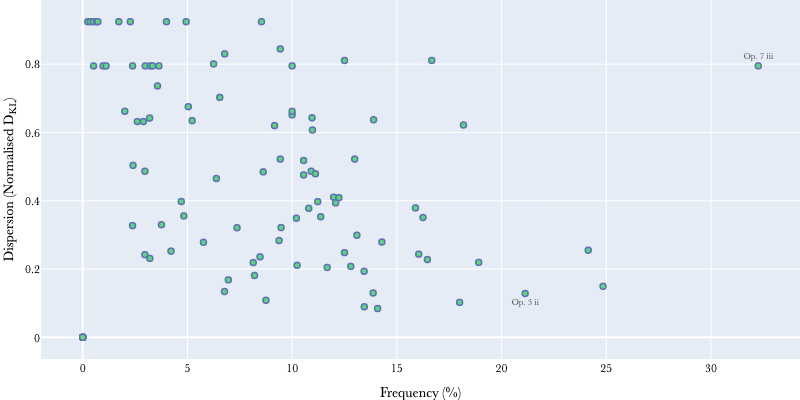

In [19]:
## this plots DKL values against frequency, with anomalies marked

organised_data = frequencies_pf.sort_values(by='[0, 1, 6]')
first_organised_data = organised_data.iloc[:len(organised_data.index)-4, :]
second_organised_data = organised_data.iloc[len(organised_data.index)-4:len(organised_data.index)-3, :]
third_organised_data = organised_data.iloc[len(organised_data.index)-3:len(organised_data.index)-1, :]
fourth_organised_data = organised_data.iloc[len(organised_data.index)-1:, :]

fig = go.Figure()
fig.add_trace(go.Scatter(x = first_organised_data['[0, 1, 6]'], y = first_organised_data['DKL Values'], mode='markers', text=first_organised_data.index.values, textposition="bottom center", textfont_size=9))
fig.add_trace(go.Scatter(x = second_organised_data['[0, 1, 6]'], y = second_organised_data['DKL Values'], mode='markers+text', text=second_organised_data.index.values, textposition="bottom center", textfont_size=9))
fig.add_trace(go.Scatter(x = third_organised_data['[0, 1, 6]'], y = third_organised_data['DKL Values'], mode='markers', text=third_organised_data.index.values, textposition="top center", textfont_size=9))
fig.add_trace(go.Scatter(x = fourth_organised_data['[0, 1, 6]'], y = fourth_organised_data['DKL Values'], mode='markers+text', text=fourth_organised_data.index.values, textposition="top center", textfont_size=9))
fig.update_layout(xaxis=(dict(title={'text': 'Frequency (%)'})))
fig.update_layout(yaxis=(dict(title={'text': 'Dispersion (Normalised D<sub>KL</sub>)'})))
fig.update_traces(marker_color='rgb(3,199,45)', marker_line_color='rgb(3,35,134)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(font=dict(family="Baskerville, monospace", size=12, color='rgb(0,0,0)'))
fig.update_layout(showlegend=False)
fig.update_layout(margin={'l': 0, 'r': 0, 't': 0, 'b': 0})
img_bytes = fig.to_image(format="png", width=800, height=400, scale=1)
fig.show()
Image(img_bytes)